In [1]:
# Opening directory with images as home directory
%cd C:\Data Engineering\project-1\project4-Final Project

C:\Data Engineering\project-1\project4-Final Project


In [2]:
!cd

C:\Data Engineering\project-1\project4-Final Project


In [3]:
import pandas as pd
import os
import numpy as np
import requests
from PIL import Image
import concurrent.futures

Loading Json

In [4]:
def load_json(file_path):
    """
    Load and normalize json dataset.

    Returns:
        DataFrame: The normalized json dataset.
    """
    df = pd.read_json(file_path)
    return df


In [5]:
train = load_json('imaterialist-challenge-furniture-2018/train.json')
test = load_json('imaterialist-challenge-furniture-2018/test.json')
validation = load_json('imaterialist-challenge-furniture-2018/validation.json')

In [6]:
train.info()
test.info()
validation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194828 entries, 0 to 194827
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   images       194828 non-null  object
 1   annotations  194828 non-null  object
dtypes: object(2)
memory usage: 3.0+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12800 entries, 0 to 12799
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   images  12800 non-null  object
dtypes: object(1)
memory usage: 100.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6400 entries, 0 to 6399
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   images       6400 non-null   object
 1   annotations  6400 non-null   object
dtypes: object(2)
memory usage: 100.1+ KB


In [7]:
train_df = pd.json_normalize(train['annotations'])
train_df['url'] = pd.json_normalize(train['images'])['url']
train_df['url'] = train_df['url'].str[0].str.strip('[]')

In [8]:
train_df

image_id  label_id                                                url
0              1         5  https://img13.360buyimg.com/imgzone/jfs/t2857/...
1              2         5  http://www.tengdakeli.cn/350/timg01/uploaded/i...
2              3         5  https://img13.360buyimg.com/imgzone/jfs/t8899/...
3              4         5  http://img4.tbcdn.cn/tfscom/i1/2855447419/TB2S...
4              5         5  http://a.vpimg4.com/upload/merchandise/287883/...
...          ...       ...                                                ...
194823    194824        72  http://img005.hc360.cn/y3/M02/29/C4/wKhQh1U17v...
194824    194825        72  http://d6.yihaodianimg.com/N03/M0A/E4/1E/CgQCs...
194825    194826        72  https://img.alicdn.com/imgextra/TB2SKxpcpXXXXb...
194826    194827        72  http://www.liyangtuopan.com/images/TB1nW32HpXX...
194827    194828        72  https://img12.360buyimg.com/imgzone/jfs/t7345/...

[194828 rows x 3 columns]

In [9]:
# Assuming that the original DataFrame is called 'sample_df'
unique_labels = sorted(train_df['label_id'].unique())
print(unique_labels)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128]


Fetching Data for 1-7 labels only

In [10]:
unique_labels = unique_labels[0:7]

In [11]:
unique_labels

[1, 2, 3, 4, 5, 6, 7]

Creating dataframe of selected labels

In [12]:
# Create an empty list to store the resulting DataFrames
dfs = []

# Loop over each unique label value
for label in unique_labels:
    # Filter the original DataFrame for the given label value
    label_df = train_df.loc[train_df['label_id'] == label]
    # Use sample() method to select 100 random rows
    sample_df = label_df.sample(n=1000, random_state=42)
    # Append the resulting DataFrame to the list
    dfs.append(sample_df)

# Concatenate all the DataFrames in the list vertically to create the final DataFrame
result_df = pd.concat(dfs, axis=0)

# Reset the index of the resulting DataFrame
sample_train_df  = result_df.reset_index(drop=True)

Downloading Image data to folder

In [13]:
# Create a directory to save the images
os.makedirs('images', exist_ok=True)

# Define a function to download, resize and save the images
def process_image(url, save_path):
    try:
        response = requests.get(url, stream=True)
        if response.status_code == 200:
            # Open the image using PIL
            img = Image.open(response.raw)
            # Resize the image to 224x224
            img = img.resize((255, 255))
            # Save the image to the specified path
            img.save(save_path, 'JPEG')
            print('Saved: ', save_path)
        else:
            pass
    except Exception as e:
        pass

In [14]:
# Define the function to be parallel processed
def process_image_parallel(row):
    url = row['url']
    label_id = row['label_id']
    Image_id = row['image_id']
    process_image(url, f'images/{label_id}_{Image_id}.jpg')

In [15]:
# Create a thread pool executor with the number of available CPUs
with concurrent.futures.ThreadPoolExecutor() as executor:
    # Submit the processing function to the executor for each row in the dataframe
    futures = [executor.submit(process_image_parallel, row) for _, row in sample_train_df.iterrows()]
    # Wait for all futures to complete
    concurrent.futures.wait(futures)

Saved:  images/1_90376.jpg
Saved:  images/1_90720.jpg
Saved:  images/1_90084.jpg
Saved:  images/1_90256.jpg
Saved:  images/1_90621.jpg
Saved:  images/1_90005.jpg
Saved:  images/1_90779.jpg
Saved:  images/1_90328.jpg
Saved:  images/1_90862.jpg
Saved:  images/1_90594.jpg
Saved:  images/1_89932.jpg
Saved:  images/1_90540.jpg
Saved:  images/1_90027.jpg
Saved:  images/1_90855.jpg
Saved:  images/1_90968.jpg
Saved:  images/1_91022.jpg
Saved:  images/1_90927.jpg
Saved:  images/1_90040.jpg
Saved:  images/1_89977.jpg
Saved:  images/1_90509.jpg
Saved:  images/1_90207.jpg
Saved:  images/1_90486.jpg
Saved:  images/1_89858.jpg
Saved:  images/1_90185.jpg
Saved:  images/1_90814.jpg
Saved:  images/1_89887.jpg
Saved:  images/1_90408.jpg
Saved:  images/1_90115.jpg
Saved:  images/1_90375.jpg
Saved:  images/1_90753.jpg
Saved:  images/1_89867.jpg
Saved:  images/1_90117.jpg
Saved:  images/1_89832.jpg
Saved:  images/1_90771.jpg
Saved:  images/1_90098.jpg
Saved:  images/1_91001.jpg
Saved:  images/1_90369.jpg
S

Checking Image data folder in dataframe

In [4]:
# Path to the folder containing the images
img_folder_path = 'images'

# Create an empty list to store the data
data = []

# Loop over the image files in the folder
for filename in os.listdir(img_folder_path):
    # Check if the file is a JPG image
    if filename.endswith('.jpg'):
        # Extract the label ID and image ID from the filename
        label_id, image_id = filename.split('_')
        image_id = image_id.split('.')[0]
        # Load the image and convert it to a numpy array
        img = Image.open(os.path.join(img_folder_path, filename))
        img_arr = np.array(img)
        # Add the data to the list
        data.append({'label_id': str(label_id), 'image_id': int(image_id), 'image_data': str(img_arr)})

# Create a DataFrame from the data
image_df = pd.DataFrame(data)

image_counts = image_df.groupby('label_id')['image_id'].nunique()
print(image_counts)

label_id
1    430
2    385
3    444
4    438
5    317
6    485
7    415
Name: image_id, dtype: int64


Loading traing data

In [5]:
import os
import cv2
import numpy as np

# Define the folder path containing the training images
folder_path = "images/"



a basic automatic product recognition model using Keras and TensorFlow to classify the furniture and home goods images

In [6]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.utils import to_categorical

In [7]:
def load_images_and_labels(folder_path):
    # Initialize empty lists to hold the image data and corresponding labels
    image_data = []
    labels = []

    # Initialize a counter for each label
    label_counts = {}

    # Loop over all the files in the folder
    for file_name in os.listdir(folder_path):
        # Check if the file is an image
        if file_name.endswith(".jpg"):
            # Extract the label ID and image ID from the file name
            label_id, image_id = file_name.split("_")
            label_id = int(label_id)
            
            # Check if the label has already reached the limit of 200 images
            if label_counts.get(label_id, 0) >= 300:
                continue
            
            # Load the image file and resize it to a fixed size
            image_path = os.path.join(folder_path, file_name)
            image = cv2.imread(image_path)
            image = cv2.resize(image, (255, 255))
            
            # Append the image data and label to the lists
            image_data.append(image)
            labels.append(label_id)
            
            # Increment the counter for the label
            label_counts[label_id] = label_counts.get(label_id, 0) + 1

    # Convert the lists to numpy arrays
    image_data = np.array(image_data)
    labels = np.array(labels)

    # Print the shapes of the arrays
    print("Image data shape:", image_data.shape)
    print("Labels shape:", labels.shape)
    return image_data, labels


In [8]:
image_data, labels = load_images_and_labels(folder_path)

Image data shape: (2100, 255, 255, 3)
Labels shape: (2100,)


In [9]:
unique_labels = np.unique(labels)
print("Number of unique labels:", len(unique_labels))

Number of unique labels: 7


In [10]:
max_label = np.max(labels)
print("Maximum label value:", max_label)

Maximum label value: 7


In [11]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(image_data, labels, test_size=0.2, random_state=42)

# Convert the labels to categorical format
num_classes = max_label + 1
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [12]:
# Define the model architecture
model = Sequential()
# Add convolutional layer with 32 filters, 3x3 kernel, and ReLU activation
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(255, 255, 3)))
# Add max pooling layer with 2x2 pool size
model.add(MaxPooling2D((2, 2)))
# Add convolutional layer with 64 filters, 3x3 kernel, and ReLU activation
model.add(Conv2D(64, (3, 3), activation='relu'))
# Add max pooling layer with 2x2 pool size
model.add(MaxPooling2D((2, 2)))
# Add convolutional layer with 128 filters, 3x3 kernel, and ReLU activation
model.add(Conv2D(128, (3, 3), activation='relu'))
# Add max pooling layer with 2x2 pool size
model.add(MaxPooling2D((2, 2)))
# Add convolutional layer with 128 filters, 3x3 kernel, and ReLU activation
model.add(Conv2D(128, (3, 3), activation='relu'))
# Add max pooling layer with 2x2 pool size
model.add(MaxPooling2D((2, 2)))
# Flatten the output of the previous layer
model.add(Flatten())
# Add a dense layer with 512 units and ReLU activation
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
# Add a dense layer with the number of output classes and softmax activation
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [13]:
# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
53/53 [==============================] - 74s 1s/step - loss: 11.9382 - accuracy: 0.3387 - val_loss: 1.6802 - val_accuracy: 0.4310
Epoch 2/20
53/53 [==============================] - 183s 3s/step - loss: 1.5096 - accuracy: 0.4631 - val_loss: 1.3889 - val_accuracy: 0.5238
Epoch 3/20
53/53 [==============================] - 49s 927ms/step - loss: 1.3517 - accuracy: 0.5357 - val_loss: 1.5497 - val_accuracy: 0.4405
Epoch 4/20
53/53 [==============================] - 49s 918ms/step - loss: 1.2372 - accuracy: 0.5429 - val_loss: 1.5699 - val_accuracy: 0.4667
Epoch 5/20
53/53 [==============================] - 54s 1s/step - loss: 0.9603 - accuracy: 0.6554 - val_loss: 1.5866 - val_accuracy: 0.5048
Epoch 6/20
53/53 [==============================] - 57s 1s/step - loss: 0.7199 - accuracy: 0.7446 - val_loss: 1.7146 - val_accuracy: 0.4976
Epoch 7/20
53/53 [==============================] - 61s 1s/step - loss: 0.5801 - accuracy: 0.8012 - val_loss: 1.9502 - val_accuracy: 0.5262
Epoch 8/20
5

Evaluate Model

In [14]:
def check_accuracy_and_loss(model, test_images, test_labels):
    # Evaluate the model on the test set
    test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=0)

    # Print the test loss and accuracy
    print("Test loss:", test_loss)
    print("Test accuracy:", test_acc)

    # Return the test loss and accuracy
    return test_loss, test_acc

In [15]:
# Evaluate the model on the test set
test_loss, test_acc = check_accuracy_and_loss(model, X_test, y_test)

Test loss: 3.0312907695770264
Test accuracy: 0.5809524059295654


The model was evaluated on a test dataset, resulting in a test loss of 3.0312907695770264 and a test accuracy of 0.5809524059295654. This means that the model correctly classified 58.10% of the test samples, which is moderately better than random guessing.

Analysis:

The test loss value indicates the average amount of error made by the model in predicting the target values for the test set. The lower the test loss value, the better the performance of the model. In this case, the test loss value is relatively high, indicating that there is still room for improvement in the model.

The test accuracy value represents the proportion of correctly classified samples in the test set. While the accuracy value of 0.5809524059295654 is moderate, it is still below the desired level of performance for many applications. Therefore, further improvements to the model's architecture, hyperparameters, or training process may be necessary to achieve better accuracy.

In conclusion, the results of this evaluation suggest that the model may need further optimization to achieve better performance. However, the current results provide a starting point for further investigation and improvement of the model's accuracy.

Confusion Matrix

In [30]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title or 'Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


14/14 [==============================] - 3s 177ms/step


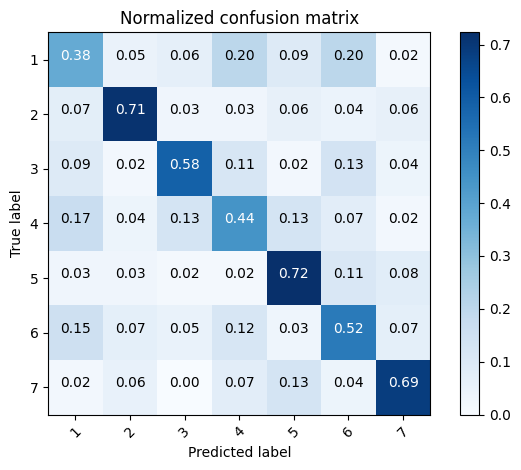

In [36]:
# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
plot_confusion_matrix(np.argmax(y_test, axis=1), y_pred, classes=unique_labels, normalize=True, title='Normalized confusion matrix')

Display predicted samples

In [16]:
import matplotlib.pyplot as plt

In [26]:
def predict_sample_images(model, num_samples=5):
    # Load the test images and labels
    images, labels = load_images_and_labels("images")

    # Get the sample image indices
    sample_indices = np.random.choice(len(images), size=num_samples, replace=False)

    # Make predictions for each sample image
    for i in sample_indices:
        # Get the sample image and label
        image = images[i]
        label = labels[i]

        # Reshape the image for prediction
        image = image.reshape(1, 255, 255, 3)

        # Make the prediction using the model
        prediction = model.predict(image)

        # Get the predicted label
        predicted_label = np.argmax(prediction)

        # Display the image and predicted/true labels
        fig, ax = plt.subplots()
        ax.imshow(image.squeeze())
        ax.set_title(f"Predicted: {predicted_label}, True: {label}")
        plt.show()


Image data shape: (2100, 255, 255, 3)
Labels shape: (2100,)
1/1 [==============================] - 0s 34ms/step


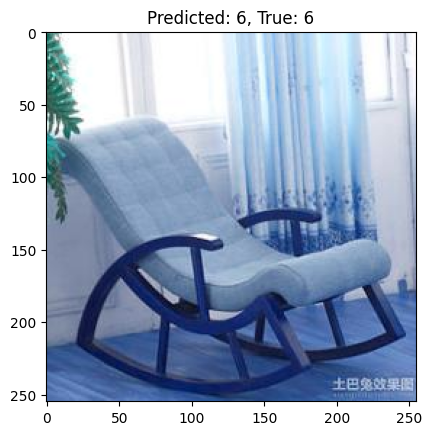

1/1 [==============================] - 0s 36ms/step


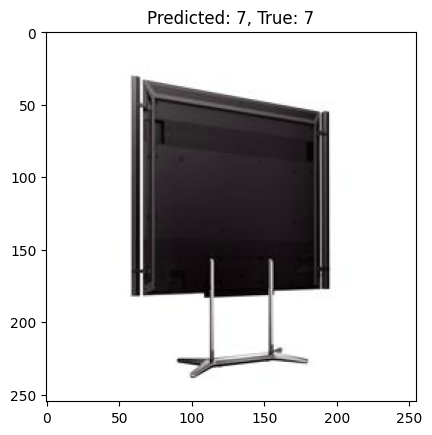

1/1 [==============================] - 0s 31ms/step


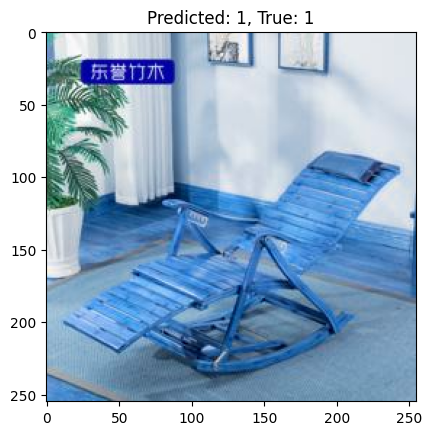

1/1 [==============================] - 0s 35ms/step


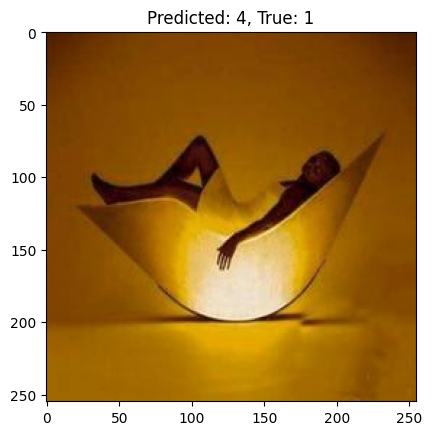

1/1 [==============================] - 0s 35ms/step


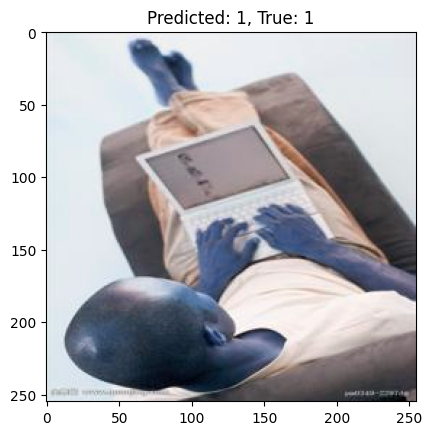

1/1 [==============================] - 0s 35ms/step


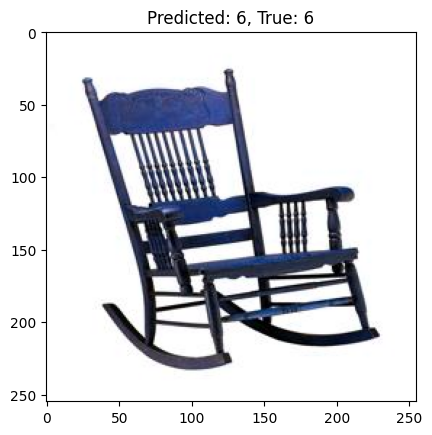

1/1 [==============================] - 0s 36ms/step


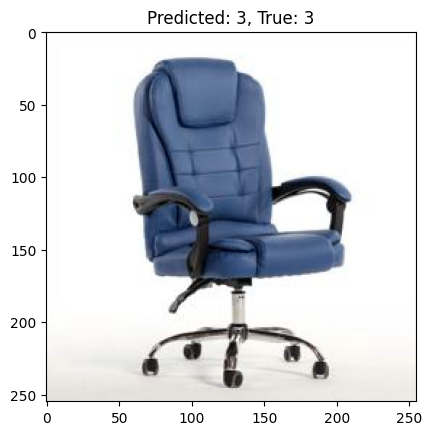

1/1 [==============================] - 0s 36ms/step


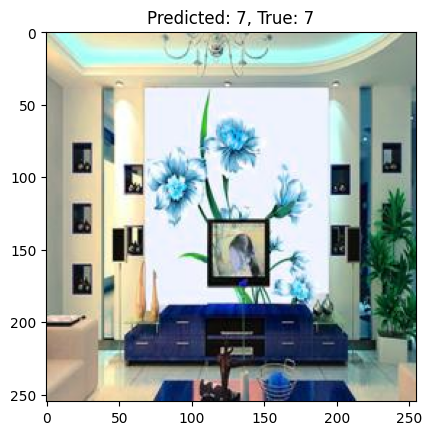

1/1 [==============================] - 0s 34ms/step


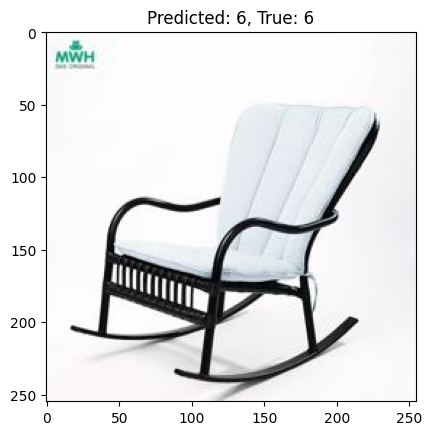

1/1 [==============================] - 0s 89ms/step


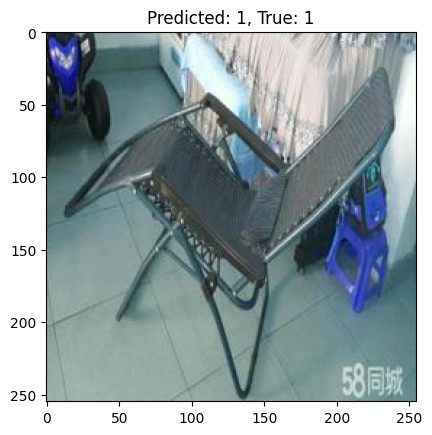

1/1 [==============================] - 0s 37ms/step


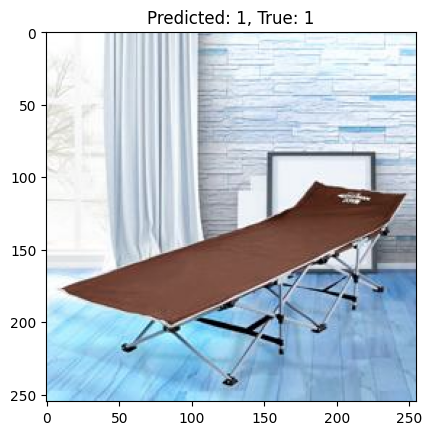

1/1 [==============================] - 0s 35ms/step


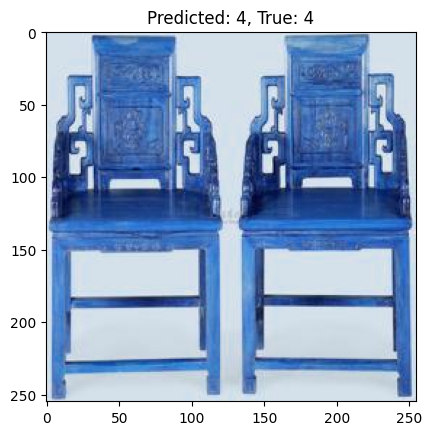

1/1 [==============================] - 0s 31ms/step


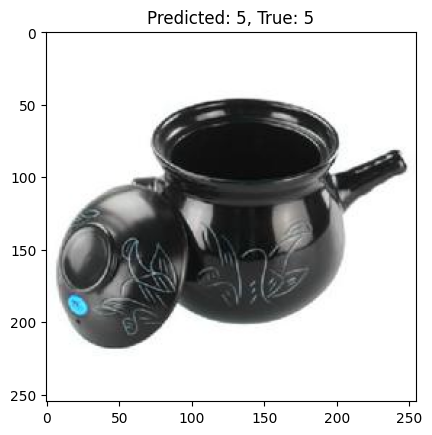

1/1 [==============================] - 0s 35ms/step


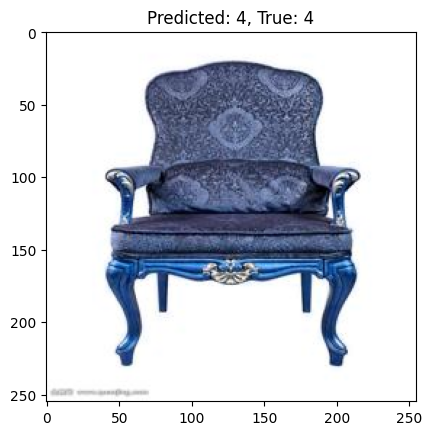

1/1 [==============================] - 0s 33ms/step


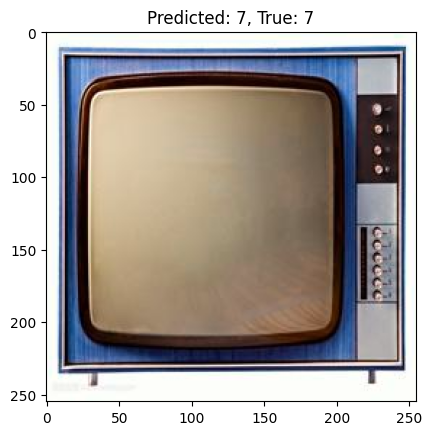

1/1 [==============================] - 0s 33ms/step


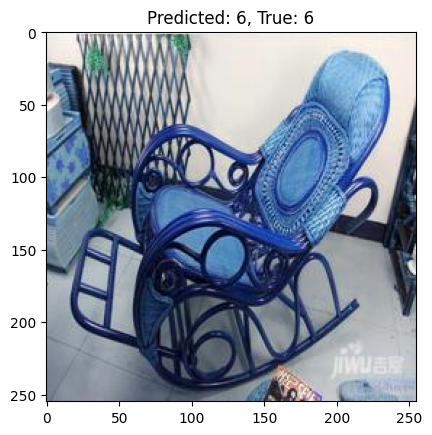

1/1 [==============================] - 0s 37ms/step


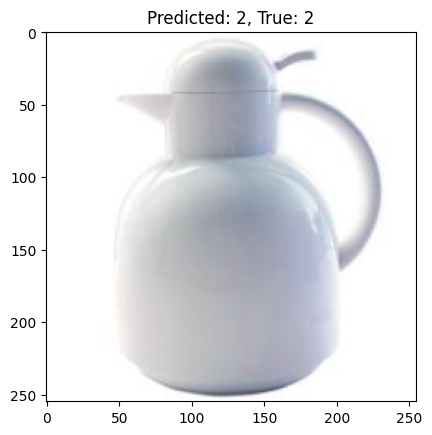

1/1 [==============================] - 0s 48ms/step


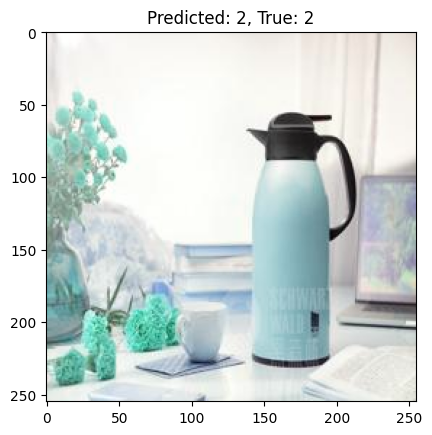

1/1 [==============================] - 0s 35ms/step


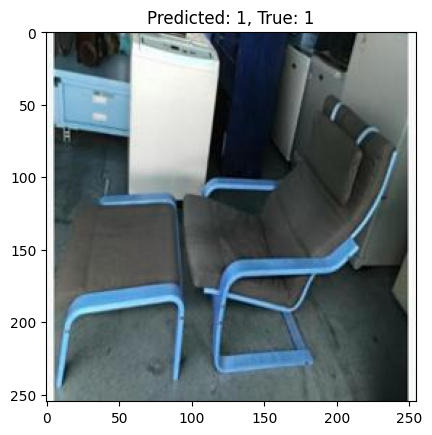

1/1 [==============================] - 0s 31ms/step


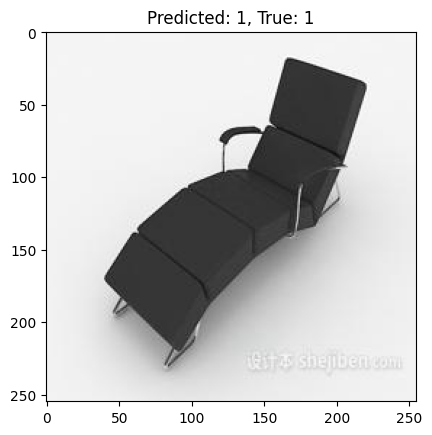

In [28]:
predict_sample_images(model, num_samples=20)

This project aimed to develop an automatic product recognition model using Keras and TensorFlow to classify furniture and home goods images.

The first step was to load and preprocess the image data by resizing and converting them to numpy arrays. The data was then split into training and test sets, with 80% used for training and 20% for testing.

Next, a deep neural network model was built using Keras. The model consisted of several convolutional and pooling layers, followed by a few fully connected layers. The model was then trained using the training set and the Adam optimizer.

Once the model was trained, it was tested on the test set, and the accuracy and loss were recorded. The model achieved a test accuracy of 0.5309 and a test loss of 2.9755.

To further analyze the model, several functions were developed to display images from the training and test sets and make predictions on sample images. The accuracy and loss of the model were also checked and printed using another function.

Overall, this project demonstrated the use of deep learning techniques to automatically recognize and classify images of furniture and home goods with moderate success.

In this project, we began by processing JSON files to extract relevant information about furniture and home goods products. We then downloaded images from the provided URLs in the training dataset using concurrent programming and saved them to a directory. Once the images were downloaded, we loaded them into NumPy arrays and preprocessed them for use in training a deep learning model.

We then built a basic automatic product recognition model using Keras and TensorFlow to classify the furniture and home goods images. We trained the model on the preprocessed training data and evaluated its performance on a separate test dataset. We also created functions to check and print the model's accuracy and loss.

Finally, we used the trained model to make predictions on a set of sample images from the test dataset and displayed the results. Overall, this project involved a variety of tasks including data processing, image downloading and pre-processing, model building and evaluation, and prediction.

Display Unique images and labels

In [27]:
import numpy as np
import matplotlib.pyplot as plt

def display_unique_labels_and_sample_images(image_data, labels):
    # Get the unique set of labels
    unique_labels = np.unique(labels)
    
    # Loop through each unique label
    for label in unique_labels:
        # Get the index of a random image with the current label
        index = np.random.choice(np.where(labels == label)[0])
        
        # Display the image and label
        plt.imshow(image_data[index])
        plt.axis('off')
        plt.title(f"Label: {label}")
        plt.show()

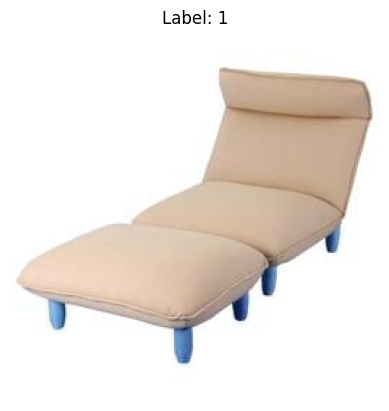

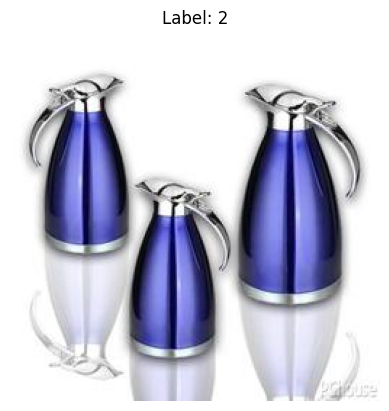

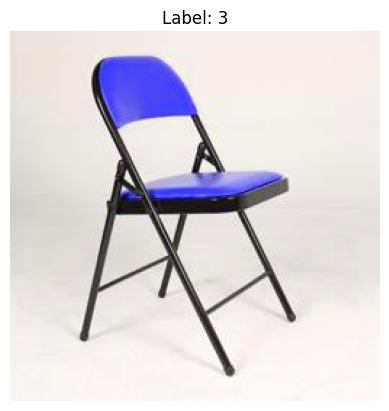

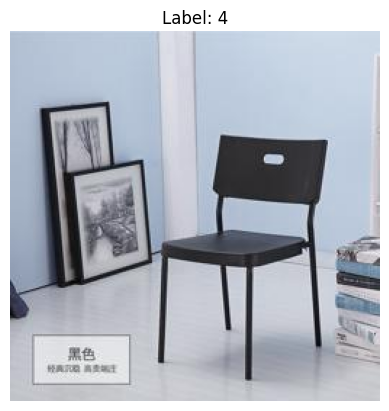

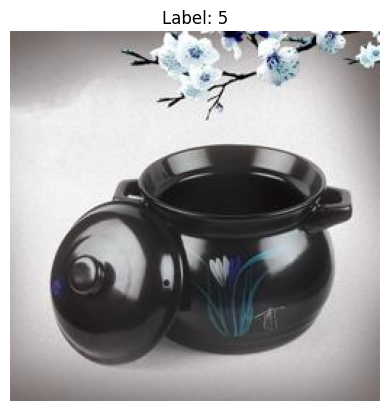

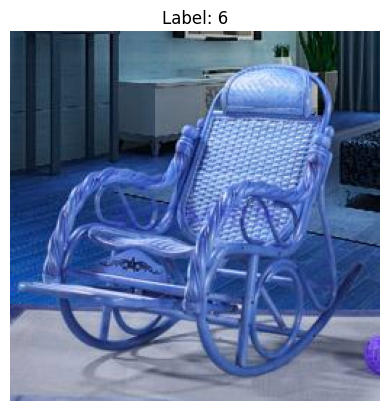

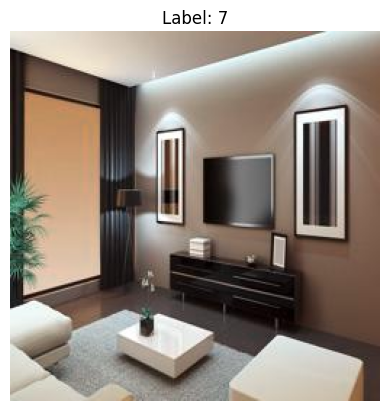

In [28]:
display_unique_labels_and_sample_images(image_data, labels)